# Visualize Simulated Boycott Results

## Goals of this notebook
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts



In [1]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt

num_users = {
    'ml-20m': 138493,
    'ml-1m': 6040
}
num_ratings = {
    'ml-20m': 20000263,
    'ml-1m': 1000209
}
for dataset in ['ml-20m', 'ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, ratio)

ml-20m 144.4135299257002
ml-1m 165.5975165562914


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [2]:
df_1m = pd.read_csv('ml-1m_collected/all_results.csv', dtype={'indices': str})
df_1m = df_1m[df_1m.ratingfrac.notna()]

In [3]:
df_20m = pd.read_csv('ml-20m_collected/all_results.csv', dtype={'indices': str})
df_20m = df_20m[df_20m.ratingfrac.notna()]

Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

In [4]:
for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    # Whoops! Assign doesn't work in a for loop.
#     df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
#     df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
#     df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]

    # drop columns we're not going to use.
    drops = [
        #'tail',
        # 'vanilla',
    ]
    for column in df.columns.values:
        for drop in drops:
            if drop in column:
                df = df.drop(column, axis=1)

# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [5]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    #'tailndcg10',
    #'ndcg5',
    #'tailndcg5',
    #'ndcgfull',
    #'tailndcgfull',
    #'ndcgfull',
    #'prec10t4',
    #'tailprec10t4',
    #'prec5t4',
    #'tailprec5t4',
]

organized_experiments = [
    'gender', 'state', 'power', 'genre', 'occupation', 'age'
]
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'SVD', 
    #'GlobalMean', 'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [6]:
dataset_to_algo_to_metric_to_altalgo = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
    'ml-20m',
]:
    standard_results = {}
    algo_to_metric_to_altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo_to_metric_to_altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo_to_metric_to_altalgo[main_algo_name][metric][st_algo_name] = 0
            if dataset == 'ml-20m':
                val = one_mill_svd.get(metric)
                if val:
                    algo_to_metric_to_altalgo[main_algo_name][metric]['1M_SVD'] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo_to_metric_to_altalgo[main_algo_name][metric]['1M_SVD'] = 0
            
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo_to_metric_to_altalgo
pprint(dataset_to_algo_to_metric_to_altalgo)

File not found: standard_results/ml-20m_ratingcv_standards_for_KNNBasic_user_msd.json
{'ml-1m': defaultdict(<function <lambda> at 0x00000236AECCAAE8>,
                      {'SVD': defaultdict(<class 'dict'>,
                                          {'ndcg10': {'KNNBaseline_item_msd': -0.21579272303199185,
                                                      'KNNBasic_item_msd': -0.783459813821296,
                                                      'KNNBasic_user_msd': -1.774069901999796,
                                                      'MovieMean': -2.527446665665193,
                                                      'SVD': 0.0},
                                           'rmse': {'KNNBaseline_item_msd': 1.326125568048003,
                                                    'KNNBasic_item_msd': 4.626236780474338,
                                                    'KNNBasic_user_msd': 5.627334338473019,
                                                    'MovieMean': 12.

## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts.

In [7]:
samples_df_20m = df_20m[df_20m['type'] == 'sample_users']
print('\n===Heterogenous 20M Boycotts===\n')
print(samples_df_20m.name.value_counts())
samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())


===Heterogenous 20M Boycotts===

41548 user sample     50
692 user sample       50
14 user sample        50
83096 user sample     50
96945 user sample     50
138 user sample       50
137108 user sample    50
13849 user sample     50
55397 user sample     50
27699 user sample     50
69 user sample        50
6925 user sample      50
1385 user sample      50
110794 user sample    50
124644 user sample    50
69246 user sample     50
Name: name, dtype: int64

===Heterogenous Boycotts===

4228 user sample    250
30 user sample      250
1 user sample       250
3020 user sample    250
60 user sample      250
5980 user sample    250
2416 user sample    250
4832 user sample    250
302 user sample     250
1208 user sample    250
3 user sample       250
5436 user sample    250
604 user sample     250
1812 user sample    250
6 user sample       250
3624 user sample    250
Name: name, dtype: int64

===Homogenous Boycotts===

male users excluded                               60
female users excluded

## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots too confusing.

In [8]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Data Manipulating Helpers
In the following two cells, we define two functions (`select_cols` and `fill_in_longform`) that will help with general purpose manipulating of our result data.

In [9]:
def select_cols(cols, metrics, groups, percents):
    """
    take a list of cols and filter based on metrics/groups/percents
    
    The returned columns must match all the metrics and groups passed
    if percents is True, return columns with "percent" in the name
    if percents is False return only columns without "percent" in the name
    
    returns a list of cols
    """
    increase_cols = [
        x for x in cols if 'increase' in x and (any(metric == x.split('_')[-2] for metric in metrics))
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [10]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [11]:
palette={'all': 'b', 'non-boycott': 'g'}
TITLE_TEMPLATE = 'Recommender Performance vs. Size of Boycott for {}'
YLABEL = 'nDCG@10 personalization factor'

In [149]:
def p_b_curve(
        df, dataset, metrics, groups,
        percents=False, normalize=True,
        reg_plot=False, hue='group', row='metric',
        save=False, show_interp=False, legend=True
    ):
    """
    Plots a performance vs. boycott size (P v B) curve
    
    Args:
        df - the dataframe to use for plotting the pb curve
        metrics - which metrics to plot the curve for.
        groups - which groups to include.
          for each metric, 
        percents - show the Y-axis in percent change or raw change. Set this True for percent change.
        normalize - should we normalize the y-axis relative to MovieMean (no personalization)
        reg_plot - ?
        hue - which facet to use to determine hue. default is group
          (each group will appear as a separate (distinctly colored) trajectory on each plot)
        row - which facet to use to split plots into different rows. default is metric.
        save - should we save a PNG file?
        show_interp - include the interpolated function on this plot?
        
    Returns:
        ?
    """
    algo_to_metric_to_altalgo=dataset_to_algo_to_metric_to_altalgo[dataset]
    
    algo_names = list(set(df.algo_name))
    df = df.copy()
    algo_to_metric_to_group_to = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    if normalize:
        for metric in metrics:
            for algo_name in algo_names:
                movie_val = abs(algo_to_metric_to_altalgo[algo_name][metric]['MovieMean'])
                for increase_col in increase_cols:
                    if increase_col.split('_')[-2] == metric:
                        df.loc[df.algo_name == algo_name, increase_col] /= movie_val
    
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)

    grid = sns.lmplot(
        x="num_users_boycotting", y="value", hue=hue, data=longform,
        sharey='row', sharex='col',
        height=5, 
        row=row, col='algo_name',
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
        palette=palette,
        legend=legend,
        legend_out=True
    )
    

    algo_to_size_to_decreases = defaultdict(lambda: defaultdict(list))
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            for group in groups:
                key = 'increase_{}_{}'.format(metric, group)
                if percents:
                    key = 'percent_' + key
                x = filt.num_users_boycotting
                user_nums = sorted(list(set(filt.num_users_boycotting)))
                nrm_rounded = sorted(list(set(filt.nrm_rounded)))
                y = filt[key]

                num_to_mean = OrderedDict()
                rounded_num_to_mean = OrderedDict()
                for num_users_boycotting in user_nums:
                    filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                    num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
                    rounded_num_to_mean[round(num_users_boycotting, 2)] = np.mean(filt_by_name[key])
                nrm_rounded_to_mean = OrderedDict()
                for num in nrm_rounded:
                    filt_by_nrm = filt[filt.nrm_rounded == num]
                    nrm_rounded_to_mean[num] = np.mean(filt_by_nrm[key])

                if group == 'non-boycott':
                    for num in [
                        0.1, 0.2, 0.3,
                    ]:
                        
                        val_nb = rounded_num_to_mean.get(num)
                        if val_nb is None:
                            continue
                        val_all = np.mean(filt[filt.num_users_boycotting == num][key.replace('non-boycott', 'all')])
                        print(
                            'Algo:{}  |  Metric:{}  |  #users:{}'.format(
                                algo_name, metric, num, 
                            )
                        )
                        print('NB Val:{}  |  ALL val:{}'.format(
                            val_nb,
                            val_all
                        ))
                        if percents is False:
                            ratio_nb = val_nb / algo_to_metric_to_altalgo[algo_name][metric]['MovieMean']
                            ratio_all = val_all / algo_to_metric_to_altalgo[algo_name][metric]['MovieMean']

                            print('ratio_nb: {}  |  ratio_all:{}'.format(
                                ratio_nb,
                                ratio_all,
                            ))
                        algo_to_size_to_decreases[algo_name][num].append(val_nb)
                meany = np.array(list(num_to_mean.values()))
                meany_ratings = np.array(list(nrm_rounded_to_mean.values()))

                algo_to_metric_to_group_to[algo_name][metric][group]['x'] = user_nums
                algo_to_metric_to_group_to[algo_name][metric][group]['y'] = meany

                smoothf_ratings = interp1d(nrm_rounded, meany_ratings, kind='linear', bounds_error=False, fill_value='extrapolate')
                algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'] = smoothf_ratings
                algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] = max(user_nums)
                algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings'] = np.linspace(
                    min(filt.num_ratings_missing), max(filt.num_ratings_missing), num=1000)

                
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        group = grid.hue_names[i_hue]
        
        lines_caption = ""
        
        lines = {}
        
        lines['MovieMean'] = {
            'value': algo_to_metric_to_altalgo[algo_name][metric]['MovieMean'],
            'color': '0.3',
            'name': 'MovieMean',
            'linestyle': '-'
        }
        lines['Zero'] = {
            'value': 0,
            'color': '0.3',
            'name': 'Zero',
            'linestyle': '-'
        }
        
        lines['KNNBasic_item_msd'] = {
            'value': algo_to_metric_to_altalgo[algo_name][metric]['KNNBasic_item_msd'],
            'color': 'r',
            'name': 'Item KNN (1999)',
            'linestyle': ':'
        }
        lines['KNNBaseline_item_msd'] = {
            'value': algo_to_metric_to_altalgo[algo_name][metric]['KNNBaseline_item_msd'],
            'color': 'y',
            'name': 'Item KNN + Baselines: 2010',
            'linestyle': ':',
        }
        if dataset == 'ml-1m':
            
            
            lines['KNNBasic_user_msd'] = {
                'value': algo_to_metric_to_altalgo[algo_name][metric]['KNNBasic_user_msd'],
                'color': 'c',
                'name': 'User KNN (1994)',
                'linestyle': ':'
            }
        elif dataset == 'ml-20m':
            lines['1M_SVD'] = {
                'value': algo_to_metric_to_altalgo[algo_name][metric]['1M_SVD'],
                'color': '0.3',
                'name': 'ml-1m SVD',
                'linestyle': ':'
            }
        
        if normalize:
            norm_val = abs(algo_to_metric_to_altalgo[algo_name][metric]['MovieMean'])
            for key in lines.keys():
                lines[key]['value'] /= norm_val
        
        ax = grid.axes[i_row, i_col]
        
        if normalize and metric == 'ndcg10':
            if dataset == 'ml-1m':
                ax.set(ylim=(-1.6, 0.1))
            elif dataset == 'ml-20m':
                ax.set(ylim=(-1.2, 0.1))
    
        linestyle = '-' if group  != 'all' else '--'

        ax.plot(
            algo_to_metric_to_group_to[algo_name][metric][group]['x'],
            algo_to_metric_to_group_to[algo_name][metric][group]['y'],
            linestyle=linestyle, color=grid._colors[i_hue]
        )
        if show_interp:
            xnew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings']
            ynew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'](xnew_ratings)
            ax.plot(
                xnew_ratings * algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] / num_ratings[dataset],
                ynew_ratings, '-')

        plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
        if percents:
            
            for line in lines.values():
                ax.axhline(line['value'], color=line['color'], linestyle=line['linestyle'])
                #ax.text(0.7, line['value'] + 0.05, line['name'])
                lines_caption += "{} colored line (value of {}) shows comparison with {}\n".format(
                    line['color'], line['value'], line['name']
                )
        print(lines_caption)

    plt.subplots_adjust(hspace=0.2)
    algo_to_size_to_mean_dec = defaultdict(dict)
    for algo_name, size2dec in algo_to_size_to_decreases.items():
        for size, decs in size2dec.items():
            algo_to_size_to_mean_dec[algo_name][size] = np.mean(decs)
    print('=====\nSize to Mean Decrease')
    pprint(algo_to_size_to_mean_dec)
                   
    grid.set_xlabels('Fraction of users boycotting')
    grid.set_ylabels(YLABEL)
    if save:
        new_labels = ['All\nUsers', 'Not\nBoycotting\nUsers',]
        if grid._legend:
            for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
            grid._legend.set_title('')
        grid.set_titles(TITLE_TEMPLATE.format(dataset.upper()))
        plt.savefig(dataset + '_pb_curve.svg', bbox_inches='tight', dpi=300)
    return algo_to_metric_to_group_to

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.06754775360839378  |  ALL val:-0.17066137274875315
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.14355844612009977  |  ALL val:-0.3353765179702833
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.2305288131116384  |  ALL val:-0.4933845828779054
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.30998075032182687) shows comparison with Item KNN (1999)
y colored line (value of -0.08537973361158853) shows comparison with Item KNN + Baselines: 2010
c colored line (value of -0.7019217956604764) shows comparison with User KNN (1994)

0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.30998075032182687) shows comparison with Item KNN (1999)
y colored line (value of -0.08537973361158853) shows comparison with Item KNN + Baselines: 2010

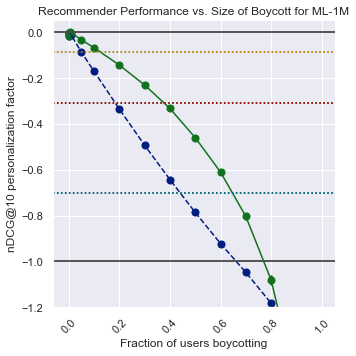

In [150]:
_ = p_b_curve(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    percents=True, normalize=True,
    metrics=['ndcg10', ],
    groups=['non-boycott', 'all', ],
    save=True, legend=False,    
)
plt.ylim(-1.2, 0.05)
plt.savefig('ml-1m_pb_curve.svg', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.007788517547258645  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.016260668657253688  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.028071160999143897  |  ALL val:nan
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.3963203167320593) shows comparison with Item KNN (1999)
y colored line (value of -0.4507662672118879) shows comparison with Item KNN + Baselines: 2010
0.3 colored line (value of -0.4242650747079455) shows comparison with ml-1m SVD

0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.3963203167320593) shows comparison with Item KNN (1999)
y colored line (value of -0.4507662672118879) shows comparison with Item KNN + Baselines: 2010
0.3 colored line (value of -0.4242650747079455) show

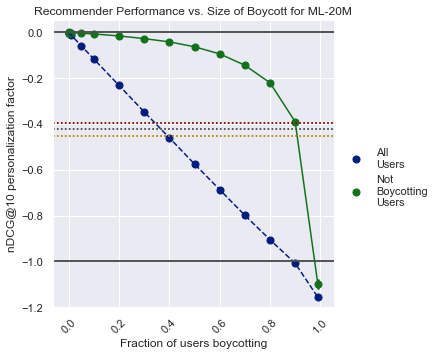

In [151]:
twenty_algo_to_metric_to_group_to = p_b_curve(
    samples_df_20m, 'ml-20m',
    show_interp=False,
    percents=True, normalize=True,
    metrics=['ndcg10'],
    groups=['non-boycott', 'all', ],
    save=True,     
)
plt.ylim(-1.2, 0.05)
plt.savefig('ml-20_pb_curve.svg', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.06754775360839378  |  ALL val:-0.17066137274875315
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.14355844612009977  |  ALL val:-0.3353765179702833
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.2305288131116384  |  ALL val:-0.4933845828779054
0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.30998075032182687) shows comparison with Item KNN (1999)
y colored line (value of -0.08537973361158853) shows comparison with Item KNN + Baselines: 2010
c colored line (value of -0.7019217956604764) shows comparison with User KNN (1994)

0.3 colored line (value of -1.0) shows comparison with MovieMean
0.3 colored line (value of 0.0) shows comparison with Zero
r colored line (value of -0.30998075032182687) shows comparison with Item KNN (1999)
y colored line (value of -0.08537973361158853) shows comparison with Item KNN + Baselines: 2010

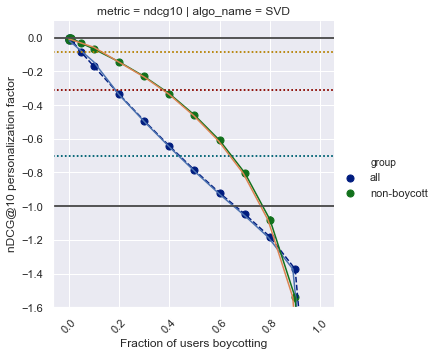

In [152]:
algo_to_metric_to_group_to = p_b_curve(
    samples_df_1m, 'ml-1m',
    metrics=metrics,
    percents=True, normalize=True, show_interp=True,
    groups=['non-boycott', 'all', ],
)
plt.show()

## Find intersection of the non-boycott curve with horizontal lines

In [153]:
movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['MovieMean']
for group in ['all', 'non-boycott']:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)):
        y = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](x)
        #print(x, y)
        if not found_item:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBaseline_item_msd']/movie_val:
                print(group + ' found item:')
                print(x / num_ratings['ml-1m'])
                found_item = True
        if not found_user:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBasic_user_msd'] / movie_val:
                print(group + ' found user')
                print(x / num_ratings['ml-1m'])
                found_user = True
        if not found_itembasic:
            if y <= dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD']['ndcg10']['KNNBasic_item_msd'] / movie_val:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['ml-1m'])
                found_itembasic = True

all found item:
0.05508848650632018
all found knnbasicitem
0.186860946062273
all found user
0.44110780846803016
non-boycott found item:
0.13327214612146063
non-boycott found knnbasicitem
0.37772105629923347
non-boycott found user
0.6473647007775375


In [154]:
movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-20m']['SVD']['ndcg10']['MovieMean']
d = {}
d[19] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.19 * num_ratings['ml-20m']) * 100
d[44] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.44 * num_ratings['ml-20m']) * 100
print(d)

{19: -1.5908953327736146, 44: -4.902099014886493}


In [155]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [156]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [157]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [158]:
NORMALIZE = True
normed_org_df = org_df.copy()
for metric in metrics:
    for algo_name in algo_names:
        movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        for group in ['non-boycott', 'like-boycott']:
            col = 'percent_increase_{}_{}'.format(metric, group)
            if NORMALIZE:
                normed_org_df.loc[
                    normed_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = 'percent_increase_{}_expected'.format(metric)
    for i, row in normed_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    normed_org_df = normed_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [159]:
def plot2(
        df, metrics, groups,
        percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
#     for name in list(set(df.name)):
#         tmp = df[df.name == name].num_ratings_missing.mean()
#         print('name', name)
#         print('mean number of ratings missing', tmp)
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
#     for metric in metrics:
#         for col in increase_cols:
#             if metric in col and 'expected' in col:
#                 expec = col
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
                elif 'like-boycott' in col:
                    lb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                lb_arr = np.array(masked[masked.increase_type == lb].value)
                
                expec_mean = np.mean(expec_arr)
                nb_mean = np.mean(nb_arr)
                lb_mean = np.nanmean(lb_arr)
                
                ratio = nb_mean / expec_mean
                diff = nb_mean - expec_mean
                lb_diff = lb_mean - nb_mean
                lb_ratio = lb_mean / expec_mean

                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff > 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Users Similar\n to Boycotting\n Users', 'Not Boycotting\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(YLABEL)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios)


In [160]:
normed_org_df = normed_org_df[normed_org_df.algo_name == 'SVD']

In [161]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']
state_boycotts = org_df[org_df['type'] == 'state']

# removing these from contention
# genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']

# Control which metrics we do comparisons for here..

In [162]:
metrics=['ndcg10']

In [163]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c'}

def plot_all_three_scenarios(df, height=6):
#     all_df = all_users_all_ratings(df)
#     if not all_df.empty:
#         grid, (total, total_sig, total_less, total_more, total_lbless), diffs, ratios = plot2(
#             all_users_all_ratings(df),
#             metrics=metrics,
#             percents=True,
#             groups=['all', 'non-boycott', 'expected'],
#             height=height,
#             palette=palette
#         )
#         grid.fig.suptitle('All Users, All Ratings')
#         print('total1', total)

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios) = plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
        
#     half_ratings_df = half_ratings(df)
#     if not half_ratings_df.empty:
#         plot2(
#             half_ratings_df,
#             metrics=metrics,
#             percents=True,
#             groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
#             height=height,
#         ).fig.suptitle('Half Ratings')
#     plt.show()
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios)

In [164]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_ratios = {
    'lb': {},
    'nb': {}
}

# Make plots for paper here.

len of df (number of experiments included) 200


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD fans of film-noir, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.3574470323375432, pval: 0.0017860842063051245
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.7934439572584691, pval: 0.00016701534992585602
ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0963237423769971, pval: 0.00011323340199027262
ndcg10 SVD power users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.9190082873239434, pval: 2.0540906574173002e-25
Totals:
4 lbless, 4 sig, 1 less, and 3 more out of 4 total


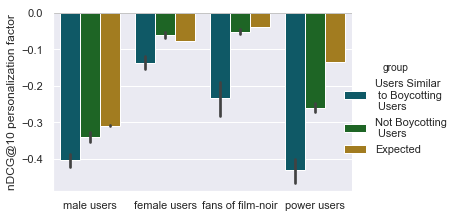

In [165]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('film-noir')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=['ndcg10'],
    percents=True,
    groups=['non-boycott', 'like-boycott', 'expected'],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=True,
    palette=palette,
    aspect=1.5
)

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df2[(df2.name.str.contains('Film-Noir')) & (df2.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     height=2.5,
#     kind='bar',
#     flip=True,
#     filename='h2.svg', save=True,
#     palette=palette
# )

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     size=2.5,
#     kind='bar',
#     flip=True,
#     filename='h3.svg', save=True,
#     palette=palette
# )

plt.show()

## Male User and Female User Boycotts

len of df (number of experiments included) 100


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.7934439572584691, pval: 0.00016701534992585602
ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0963237423769971, pval: 0.00011323340199027262
Totals:
2 lbless, 2 sig, 1 less, and 1 more out of 2 total
total2 2 2


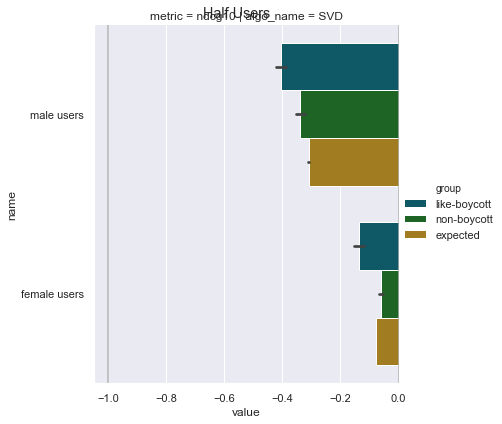

In [166]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

len of df (number of experiments included) 100


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD bottom 10% contributors, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.30039856848456054, pval: 0.0019857762625803983
ndcg10 SVD power users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.9190082873239434, pval: 2.0540906574173002e-25
Totals:
2 lbless, 2 sig, 1 less, and 1 more out of 2 total
total2 2 2


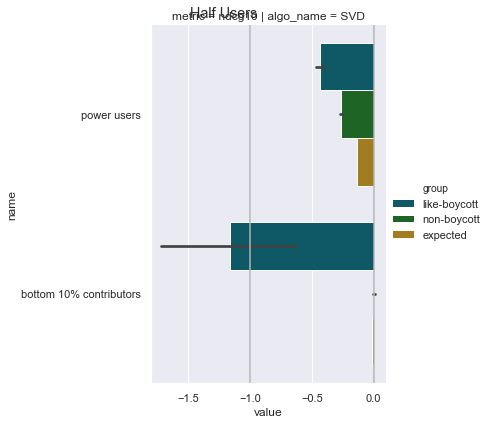

In [167]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])


plt.show()

# Age Boycotts

len of df (number of experiments included) 350


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD under 18, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.020090789404979194, pval: 0.0011997178613798237
ndcg10 SVD 45-49, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.8913736780844764, pval: 0.4496784309904025
ndcg10 SVD 50-55, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.7976365131326462, pval: 0.22497379448772015
ndcg10 SVD 18-24, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.33780774440666, pval: 8.213290415012035e-05
ndcg10 SVD 25-34, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0904646330670862, pval: 0.011923611683828278
ndcg10 SVD 56+, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.1970748476723377, pval: 1.8032059689161897e-05
ndcg10 SVD 35-44, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0820044054403612, pval: 0.25410402127978704
Tota

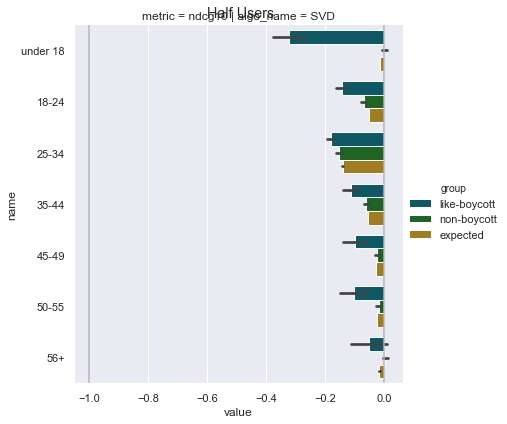

In [168]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()


# Occupation Boycotts

len of df (number of experiments included) 1050


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD tradesman/craftsman, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.17117790251498288, pval: 0.0006068399427131337
ndcg10 SVD sales/marketing, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.9681400963753205, pval: 0.8504823327054023
ndcg10 SVD scientist, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.36670753997988376, pval: 0.07232910164152052
ndcg10 SVD doctor/health care, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6285599083434869, pval: 0.1783196241607691
ndcg10 SVD self-employed, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6857615226311611, pval: 0.06210469421322799
ndcg10 SVD college/grad student, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0574700997918913, pval: 0.575578568383889
ndcg10 SVD retired, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott

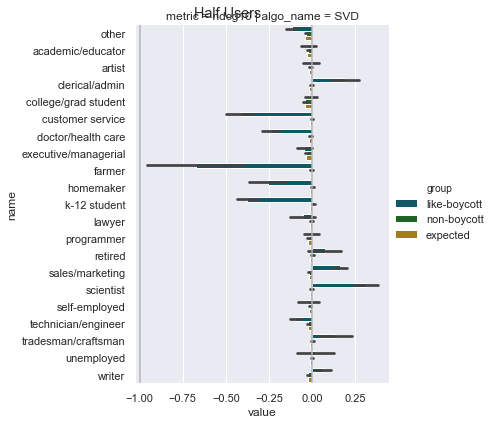

In [169]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
plt.show()

# Genre Boycotts

len of df (number of experiments included) 900


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ndcg10 SVD fans of fantasy, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.5090996649094666, pval: 0.03431827361239725
ndcg10 SVD fans of sci-fi, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.29891254110928106, pval: 2.955404768453154e-07
ndcg10 SVD fans of war, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0419729177834929, pval: 0.39673677239676775
ndcg10 SVD fans of horror, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.7760951205076158, pval: 0.29605851012694406
ndcg10 SVD fans of children's, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.5419978236225189, pval: 0.000660917102920723
ndcg10 SVD fans of animation, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.0158401645330821, pval: 0.8363465945937836
ndcg10 SVD fans of western, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-bo

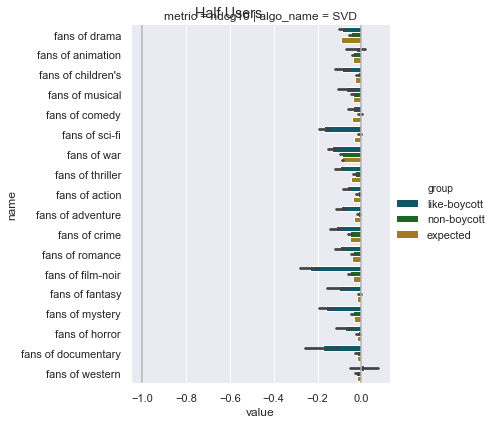

In [170]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios) = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])

plt.show()

In [171]:
running_totals

{'total': 50,
 'total_lbless': 37,
 'total_less': 36,
 'total_more': 14,
 'total_sig': 41}

In [172]:
from pprint import pprint
pprint(all_diffs)
pprint(all_ratios)

{'lb': {'18-24': -0.07422645573381648,
        '25-34': -0.024862169783425536,
        '35-44': -0.05291675983953624,
        '45-49': -0.07340881502334753,
        '50-55': -0.08478266186702534,
        '56+': -0.056760111460816325,
        'academic/educator': 0.0024312017968756774,
        'artist': 0.003849788854826925,
        'bottom 10% contributors': -1.165898456682662,
        'clerical/admin': 0.197728386057877,
        'college/grad student': 0.03473085400089548,
        'customer service': -0.41496029200860923,
        'doctor/health care': -0.22790064299734622,
        'executive/managerial': -0.01602541212569883,
        'fans of action': -0.05034776084376496,
        'fans of adventure': -0.07834766365025918,
        'fans of animation': 0.012914031850264594,
        "fans of children's": -0.07075534277333252,
        'fans of comedy': -0.030208322279931695,
        'fans of crime': -0.0664415480117897,
        'fans of documentary': -0.1524936080835349,
        'fans of

In [173]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)